In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np 


100


/tmp/ipykernel_2025498/334571296.py:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.index=pd.date_range(start='2000Q1',end='2025Q1',freq='Q')


<Axes: >

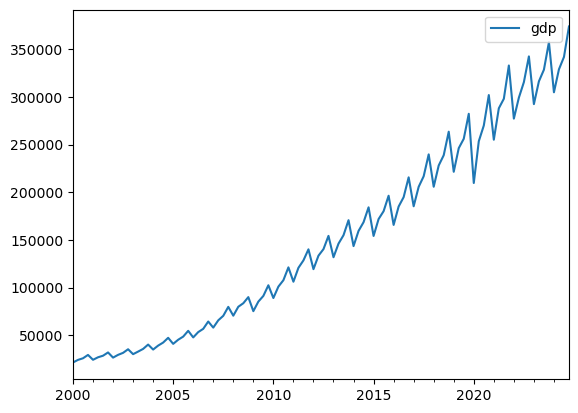

In [3]:
data="373726.2	341758.0	328837.6	304761.8	357224.8	328440.7	316237.5	292368.8	342342.4	315399.6	299111.5	277175.8	332826.7	297961.9	287979.2	255055.2	301836.2	269910.2	253450.0	209671.1	282201.4	256023.2	246193.9	221453.9	263435.6	238796.8	228042.4	205735.3	239687.6	216755.3	205665.6	185274.4	215617.9	194837.5	185002.2	165735.3	196334.4	180118.7	171887.0	154171.4	184179.4	168601.7	159462.4	143539.4	170694.7	154972.1	146113.9	131879.7	154258.0	140384.0	133491.2	119377.5	140150.3	128561.5	120776.8	106218.9	121260.4	107792.9	101075.0	89125.0	102494.7	91330.0	85355.6	75341.3	90075.0	83668.3	79965.0	70609.6	79854.0	70494.1	65751.0	58080.6	64510.8	56820.5	53415.3	47831.7	54746.8	48681.7	45399.8	41079.2	47420.3	42448.0	39251.8	35107.8	40338.8	35778.3	32978.2	30282.0	35430.7	31664.4	29550.7	26666.0	32086.9	28662.0	27017.8	24390.6	29488.6	25973.8	24277.1	21569.1"
data=data.strip().split('\t')
data=[float(i) for i in data]
data.reverse()
print(len(data))
data=pd.DataFrame(data,columns=['gdp'])
data.index=pd.date_range(start='2000Q1',end='2025Q1',freq='Q')
data.plot()

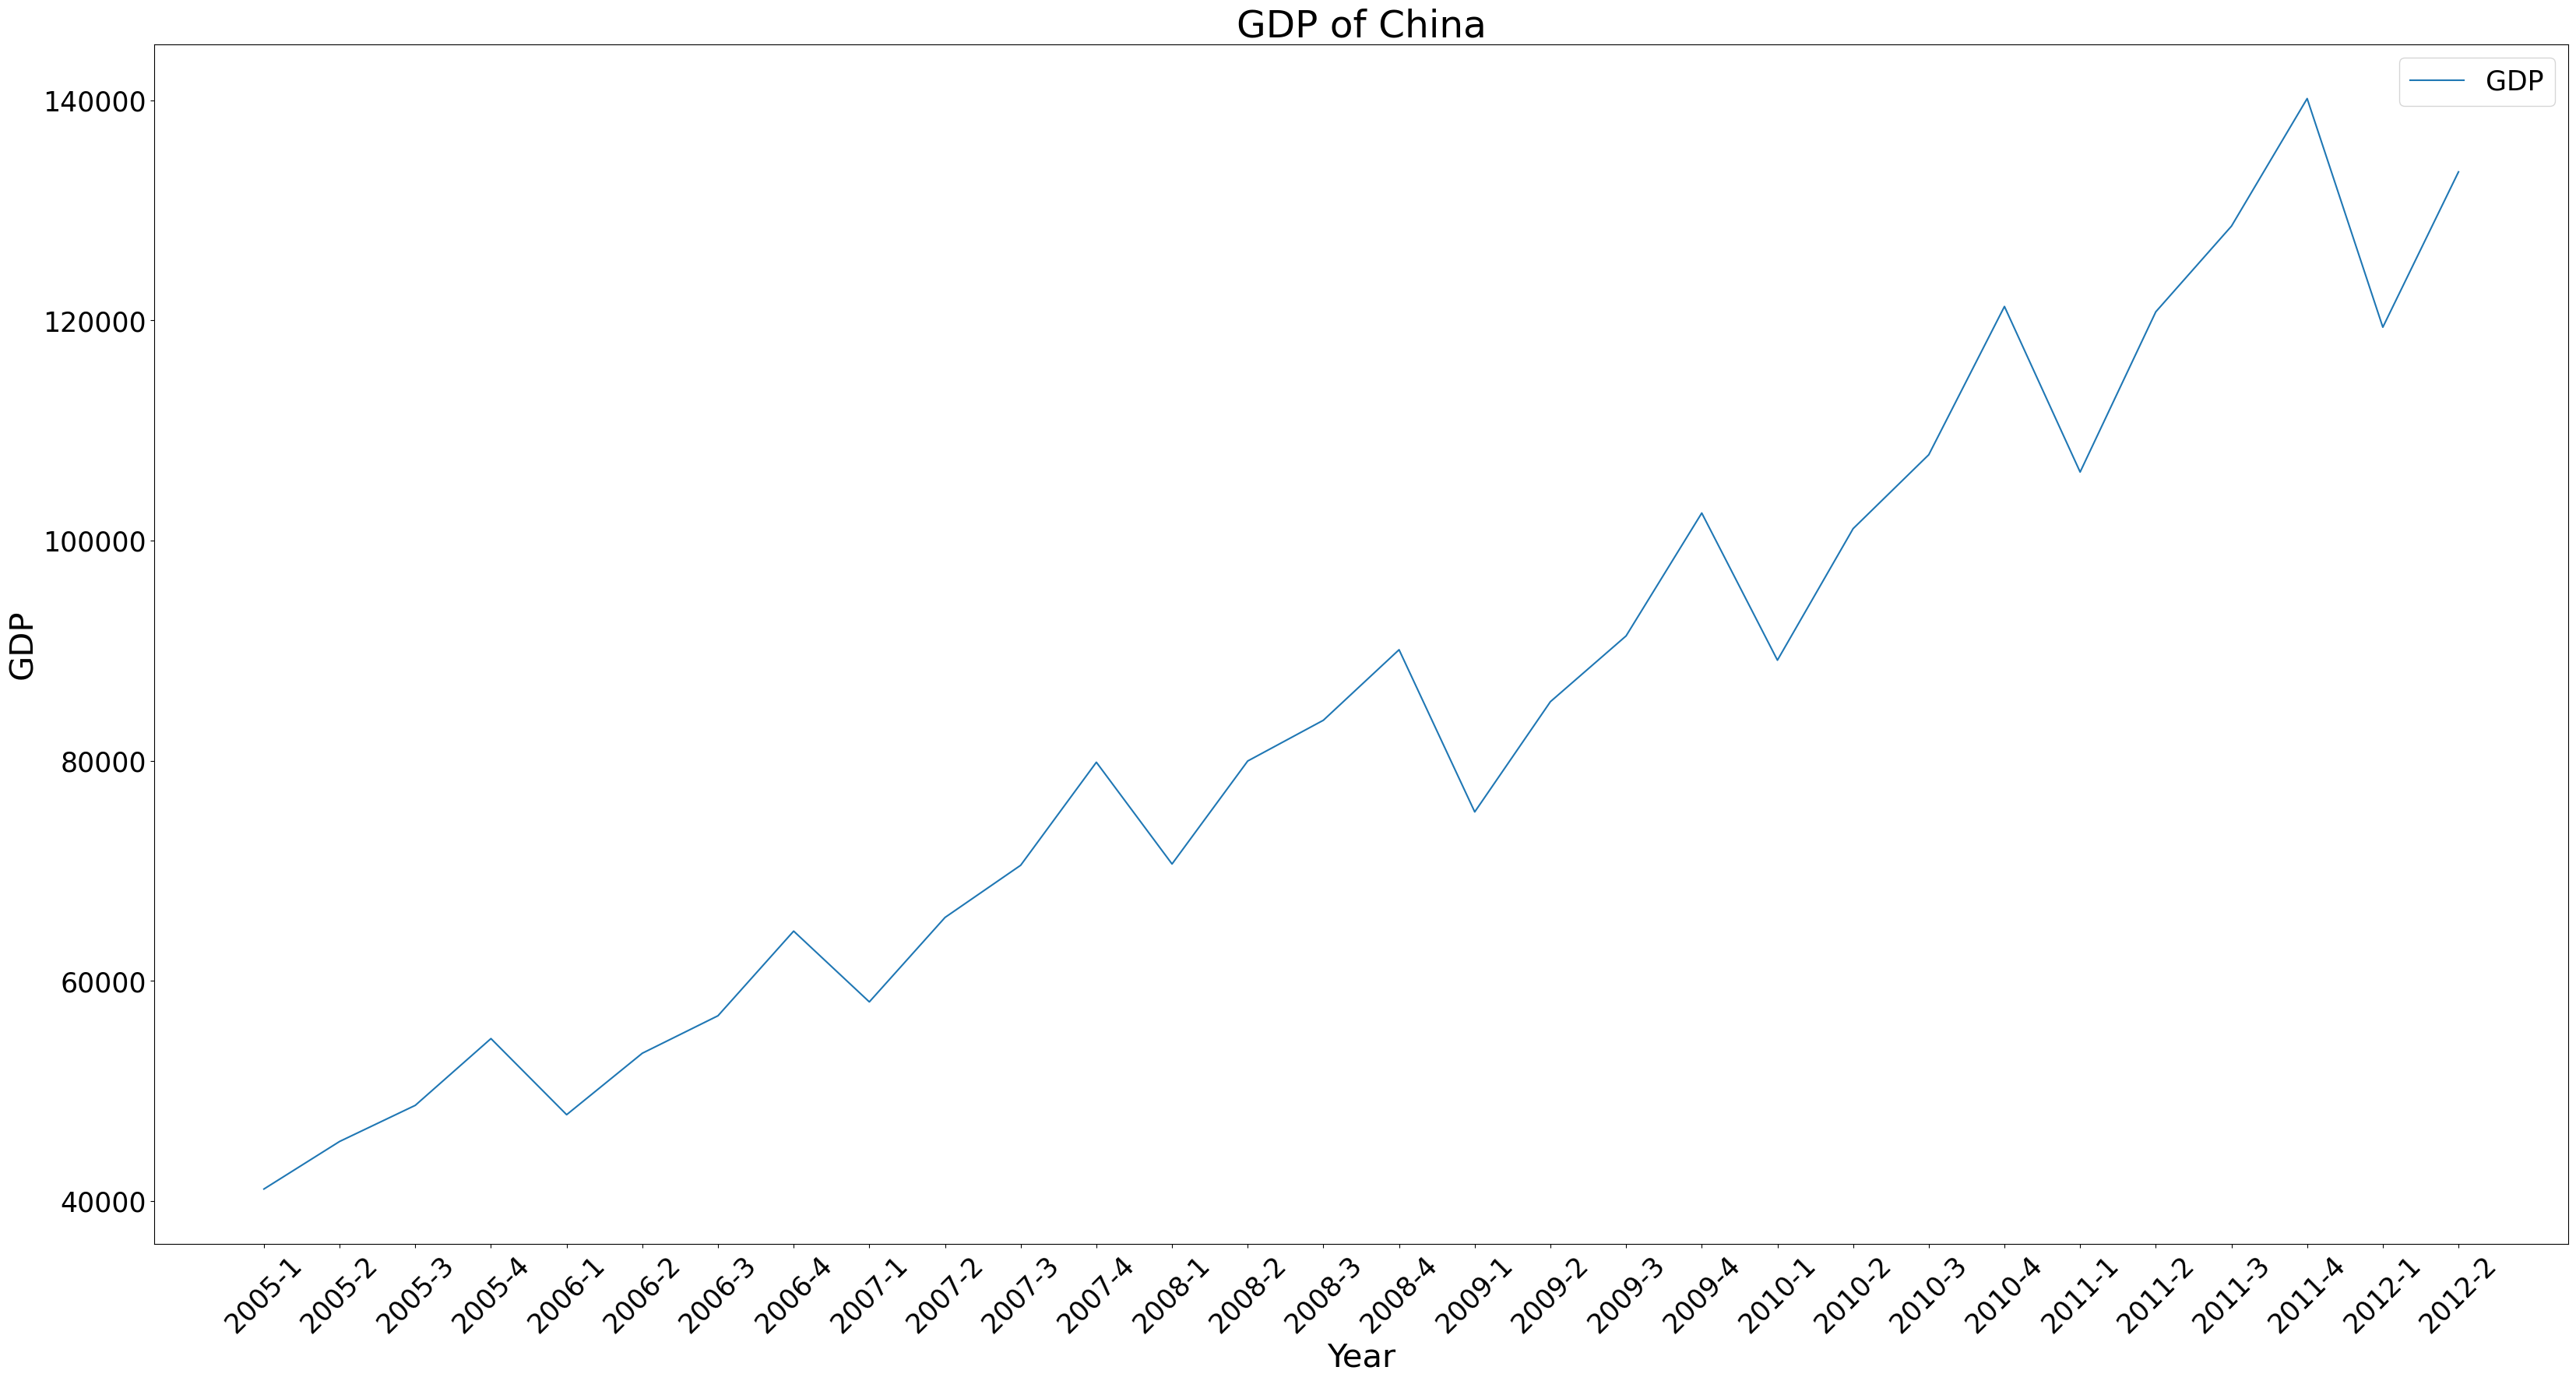

In [4]:
x=[str(2000+i)+'-'+str(j) for i in range(0,25) for j in range(1,5)]
plt.figure(figsize=(40,20))
plt.plot(x[20:50],data['gdp'][20:50],label='GDP')

plt.xticks(rotation=45,fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Year',fontsize=30)
plt.ylabel('GDP',fontsize=30)
plt.title('GDP of China',fontsize=35)
plt.legend(fontsize=25)
plt.show()

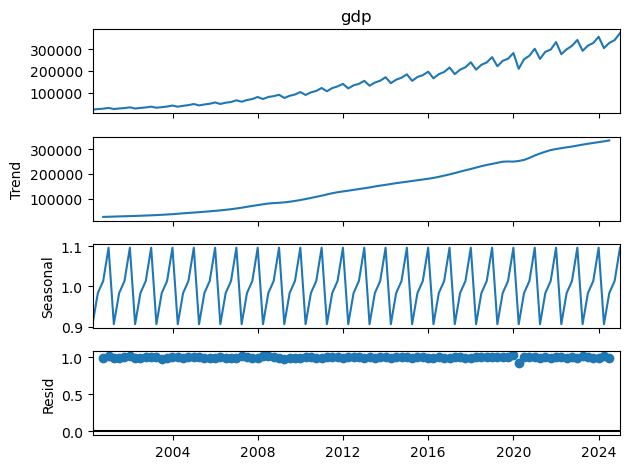

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose 
result=seasonal_decompose(data['gdp'],model='multiplicative',period=4)
result.plot()
plt.tight_layout()
plt.show()

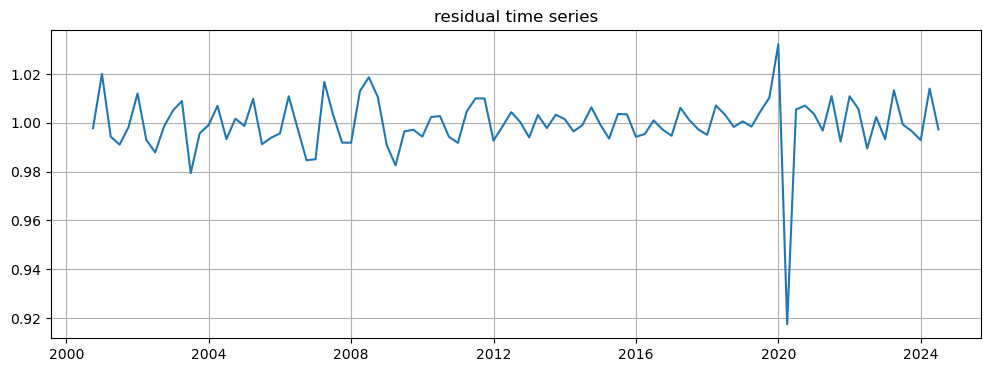

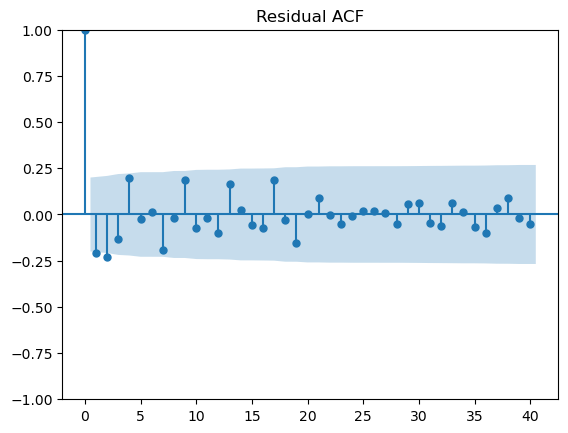

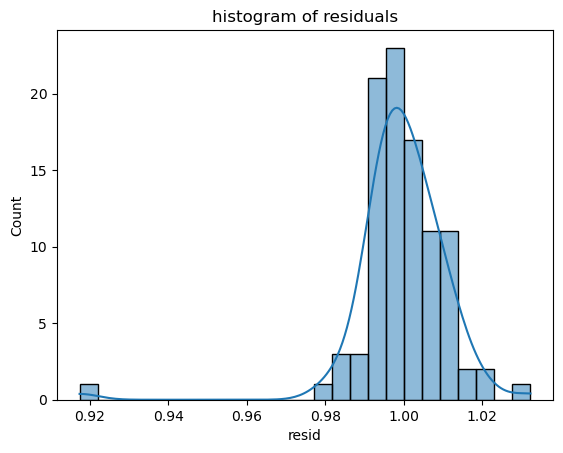

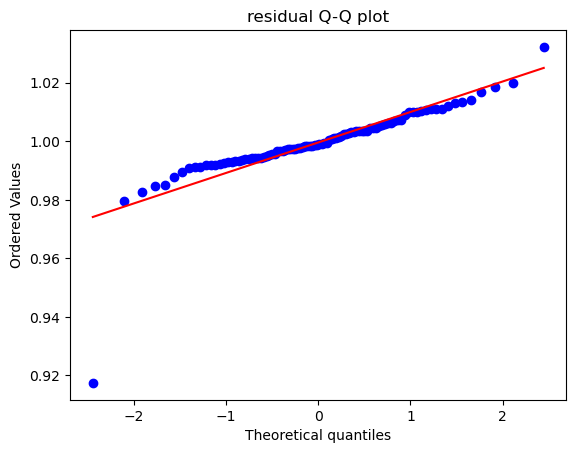

ADF: 8.340433781908204e-16


In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import scipy.stats as stats

resid=result.resid.dropna()
def resid_test(resid):
    # 1. 残差时间图
    plt.figure(figsize=(12, 4))
    plt.plot(resid)
    plt.title('residual time series')
    plt.grid(True)
    plt.show()

    # 2. 残差的 ACF 图（检查自相关）
    plot_acf(resid, lags=40)
    plt.title("Residual ACF")
    plt.show()

    # 3. 正态性检验（直方图 + QQ图）
    sns.histplot(resid, kde=True)
    plt.title('histogram of residuals')
    plt.show()

    stats.probplot(resid, dist="norm", plot=plt)
    plt.title('residual Q-Q plot')
    plt.show()

    # 4. 平稳性检验（ADF）
    adf_result = adfuller(resid.dropna())
    print(f"ADF: {adf_result[1]}")
resid_test(resid)

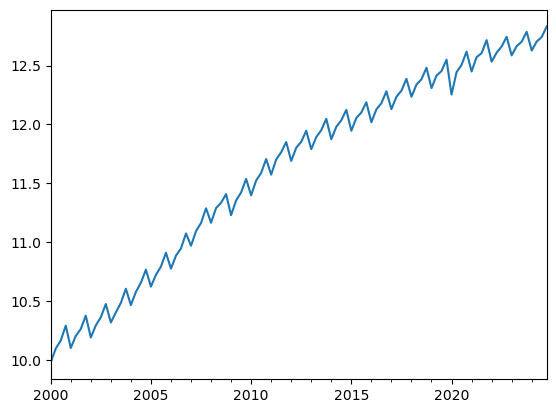

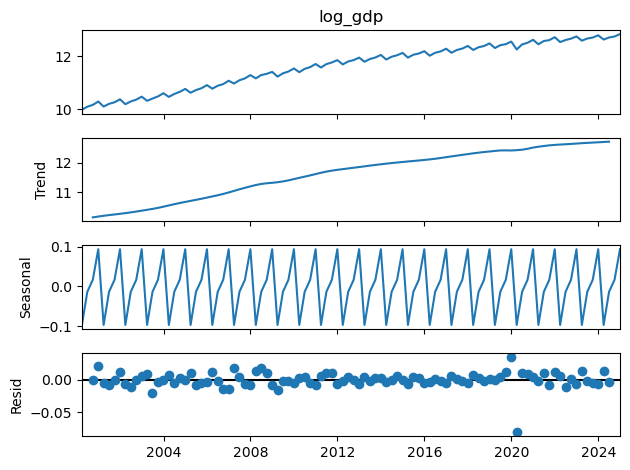

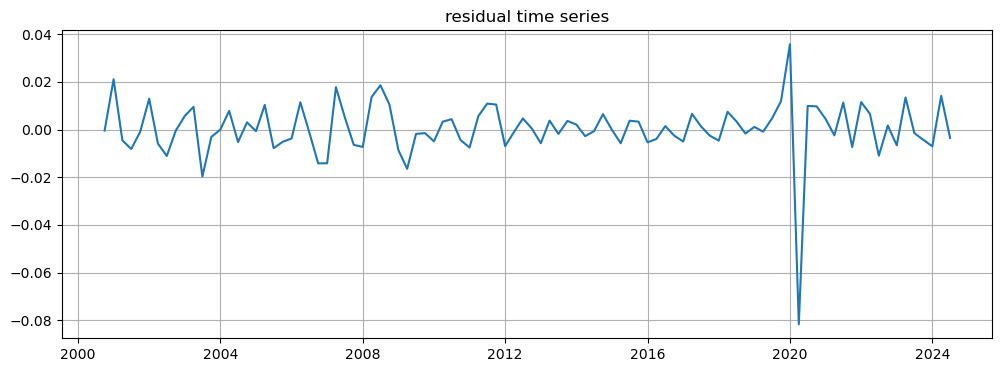

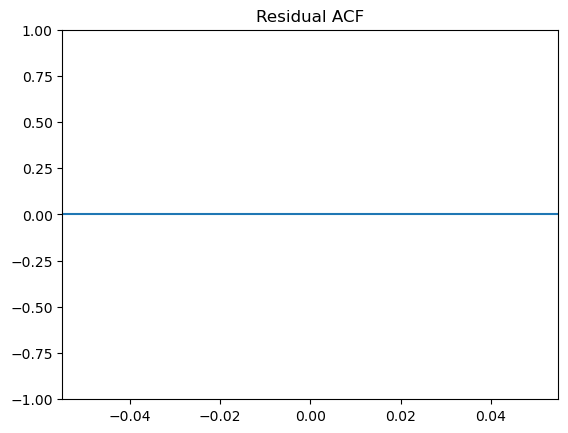

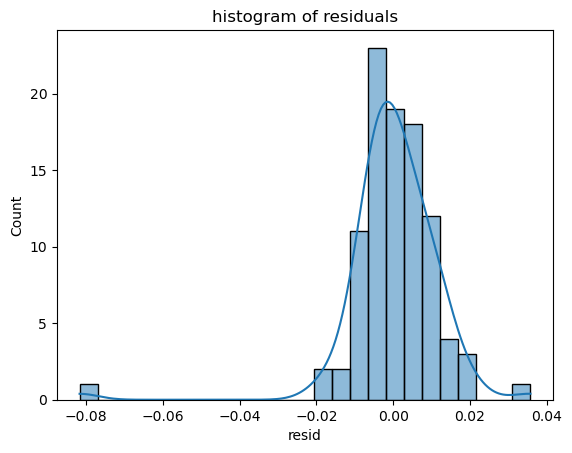

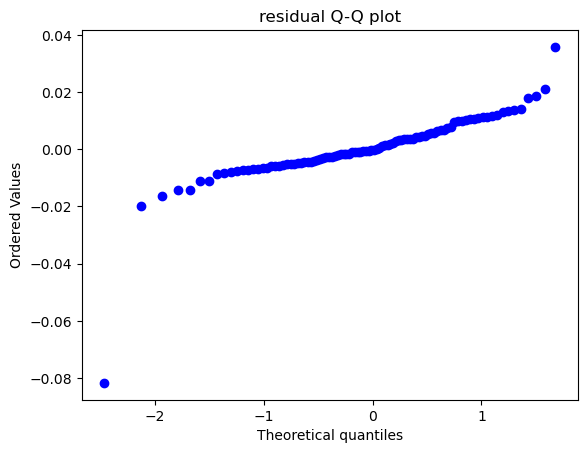

ADF: 5.738936041237467e-17


In [7]:
data['log_gdp']=np.log(data['gdp'])
data['log_gdp'].plot()
result=seasonal_decompose(data['log_gdp'],model='additive',period=4)
result.plot()
resid_test(result.resid)

In [8]:
data['log_gdp'].diff().diff(4).dropna()

2001-06-30   -0.015974
2001-09-30   -0.008479
2001-12-31   -0.014040
2002-03-31    0.004747
2002-06-30    0.000420
                ...   
2023-12-31    0.002038
2024-03-31   -0.001039
2024-06-30   -0.002444
2024-09-30    0.000676
2024-12-31    0.005412
Freq: QE-DEC, Name: log_gdp, Length: 95, dtype: float64

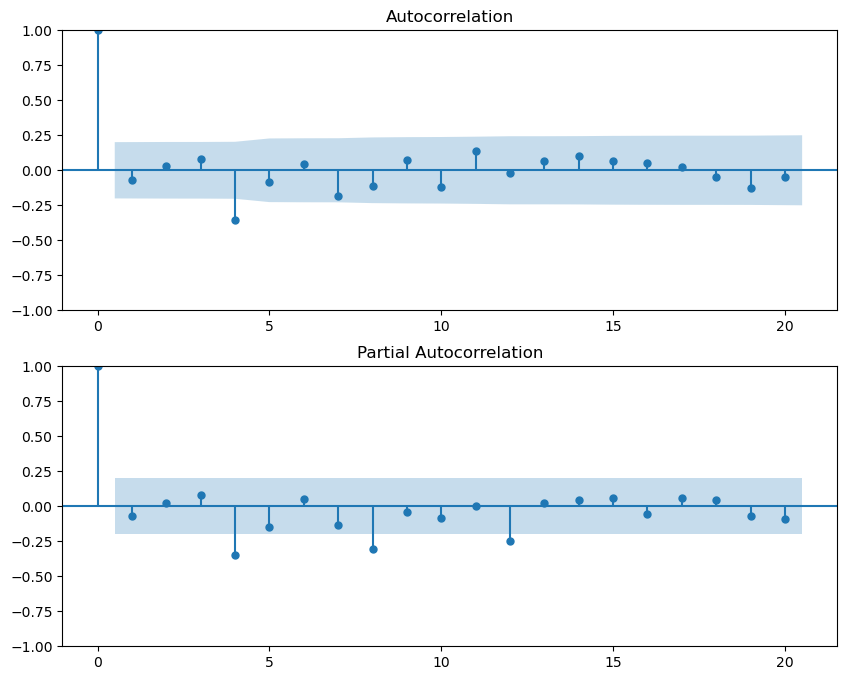

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.subplots(2,1,figsize=(10,8))

plot_acf(data['log_gdp'].diff().diff(4).dropna(), lags=20, ax=plt.subplot(2,1,1))

plot_pacf(data['log_gdp'].diff().diff(4).dropna(), lags=20, ax=plt.subplot(2,1,2))
plt.show()

网格法选择模型参数

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 尝试 q=0~2
for q in range(3):
    for p in [0,1,2]:
        for P in [1,2,3]:
            model = SARIMAX(data['log_gdp'], 
                            order=(p, 1, q), 
                            seasonal_order=(P, 1, 1, 4))
            result = model.fit(disp=False)
            print(f"q={q},p={p},P={P} AIC={result.aic:.2f}, BIC={result.bic:.2f}")


自动选择最佳模型参数

In [11]:
import pmdarima as pm

model = pm.auto_arima(data['log_gdp'],
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      d=1,
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2,
                      D=1,
                      seasonal=True,
                      m=4,        
                      stepwise=True,
                      trace=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-415.294, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-424.550, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-437.672, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-413.687, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-438.518, Time=0.16 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-424.461, Time=0.06 sec
 ARIMA(0,1,1)(2,1,1)[4]             : AIC=-436.634, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=-436.621, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-438.607, Time=0.18 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=-440.168, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-438.726, Time=0.03 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=-438.212, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-440.164, Time=0.07 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-438.686, Time=0.14 sec
 ARIMA(1,1,1)(0,1,2)[4]          

In [13]:
model = SARIMAX(data['log_gdp'][:-8],
                order=(0, 1, 0),
                seasonal_order=(1, 1, 1, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05641D+00    |proj g|=  4.38923D+00

At iterate    5    f= -2.06008D+00    |proj g|=  2.36494D-01

At iterate   10    f= -2.06178D+00    |proj g|=  2.12329D+00

At iterate   15    f= -2.06307D+00    |proj g|=  4.01688D-02

At iterate   20    f= -2.06350D+00    |proj g|=  5.29860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     31      1     0     0   4.827D-04  -2.064D+00
  F =  -2.0635031349750053     

CONVERG

 This problem is unconstrained.


2001-06-30    10.224715
2001-09-30    10.274371
2001-12-31    10.395061
2002-03-31     9.883426
2002-06-30    10.292230
                ...    
2021-12-31    12.706722
2022-03-31    12.531623
2022-06-30    12.656573
2022-09-30    12.656041
2022-12-31    12.765355
Freq: QE-DEC, Length: 87, dtype: float64
2001-06-30     27576.391305
2001-09-30     28980.279432
2001-12-31     32697.748067
2002-03-31     19602.770048
2002-06-30     29502.485061
                  ...      
2021-12-31    329958.330729
2022-03-31    276958.484613
2022-06-30    313819.279672
2022-09-30    313652.452159
2022-12-31    349883.413484
Freq: QE-DEC, Length: 87, dtype: float64


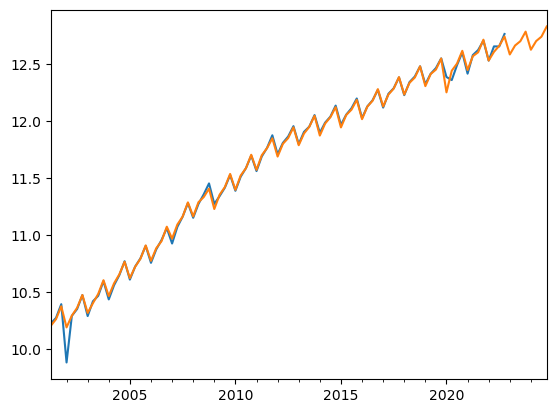

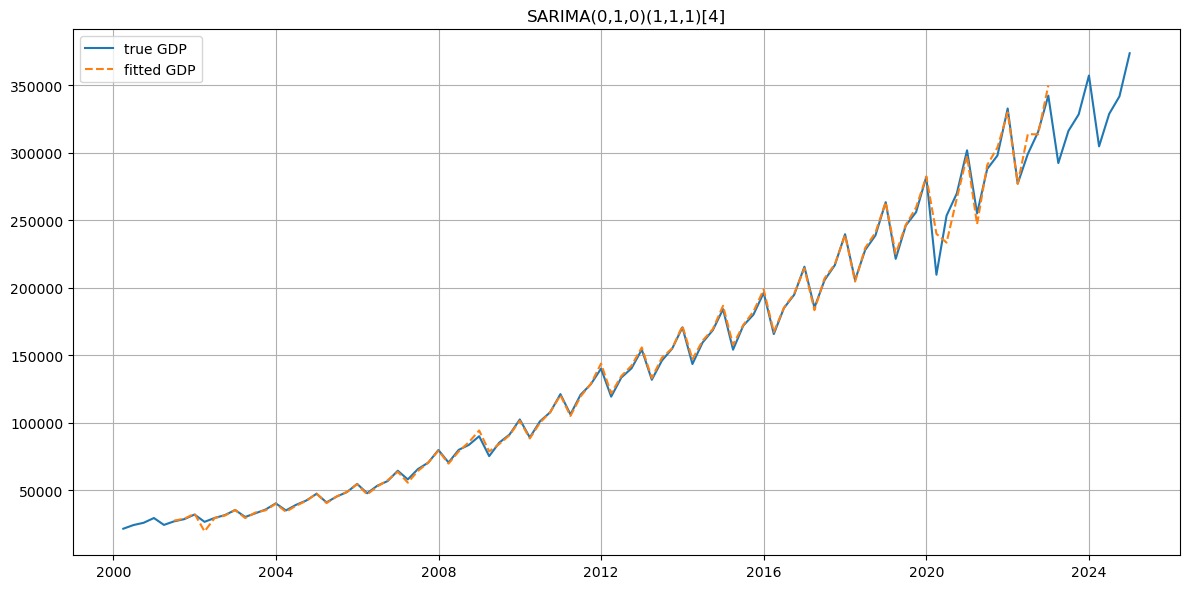

(-9.690448532396712, 1.1402421893482938e-16, 0, 86, {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}, -339.0431085138821)


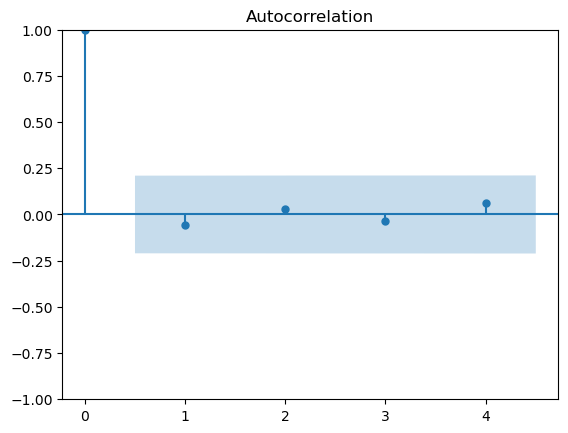

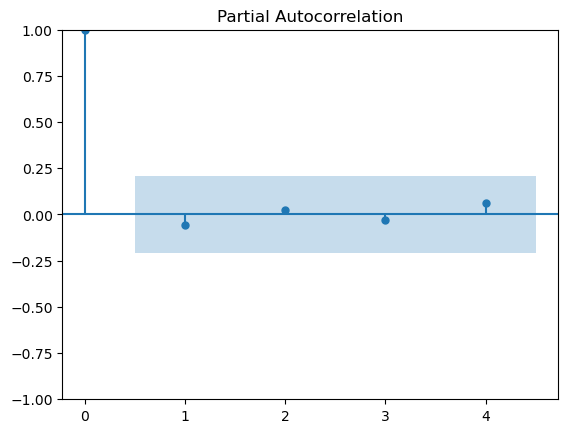

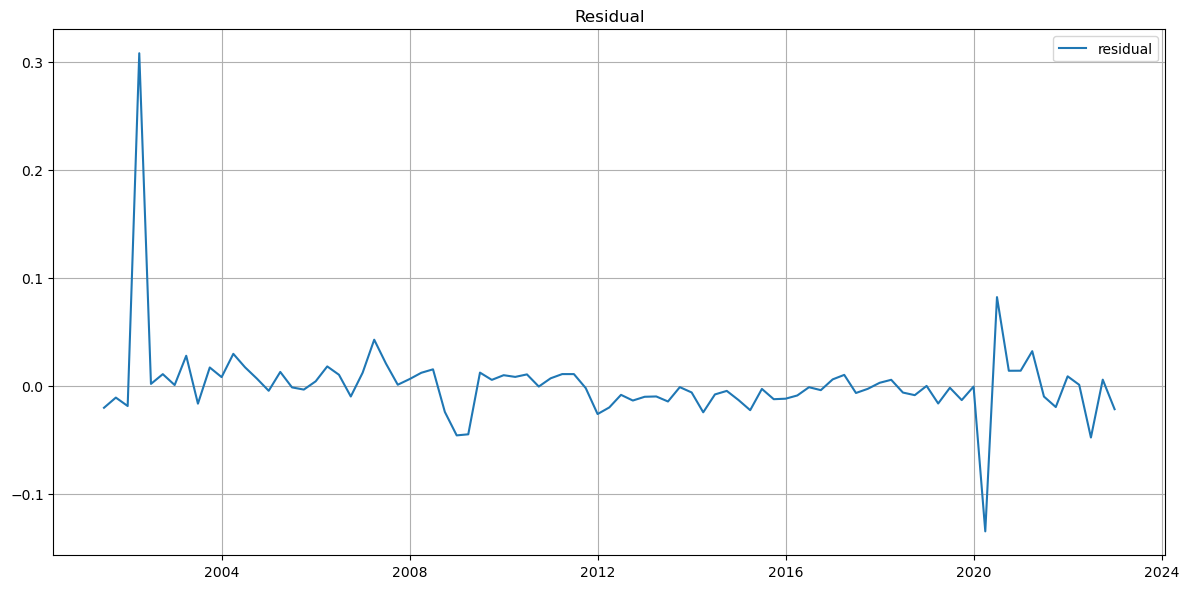

In [23]:
fitted_log = result.fittedvalues[5:]
print(fitted_log)

fitted_log.plot()
data['log_gdp'][5:].plot()
fitted = np.exp(fitted_log)  # 还原回原始 GDP 单位
print(fitted)
# 拟合图
plt.figure(figsize=(12, 6))
plt.plot(data['gdp'], label='true GDP')
plt.plot(fitted, label='fitted GDP', linestyle='--')
plt.title('SARIMA(0,1,0)(1,1,1)[4]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#residual test
residual = result.resid[5:]

# 平稳性检验
adf_test = adfuller(residual)
print(adf_test)
import statsmodels.api as sm

# 白噪声检验
# 白噪声检验结果：p值小于0.05，拒绝原假设，认为数据为非白噪声，否则为白噪声。 
sm.stats.diagnostic.acorr_ljungbox(residual, lags=4)  # lags=4 代表检验阶数为 4

# ACF
sm.graphics.tsa.plot_acf(residual, lags=4)
# PACF
sm.graphics.tsa.plot_pacf(residual, lags=4)

# 偏差图
plt.figure(figsize=(12, 6))
plt.plot(residual, label='residual')
plt.title('Residual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()  

预测

            lower log_gdp  upper log_gdp
2023-03-31      12.513004      12.604743
2023-06-30      12.604502      12.734239
2023-09-30      12.640015      12.798910
2023-12-31      12.724661      12.908137
2024-03-31      12.522431      12.740718
2024-06-30      12.620547      12.868810
2024-09-30      12.657052      12.932043
2024-12-31      12.742949      13.042292


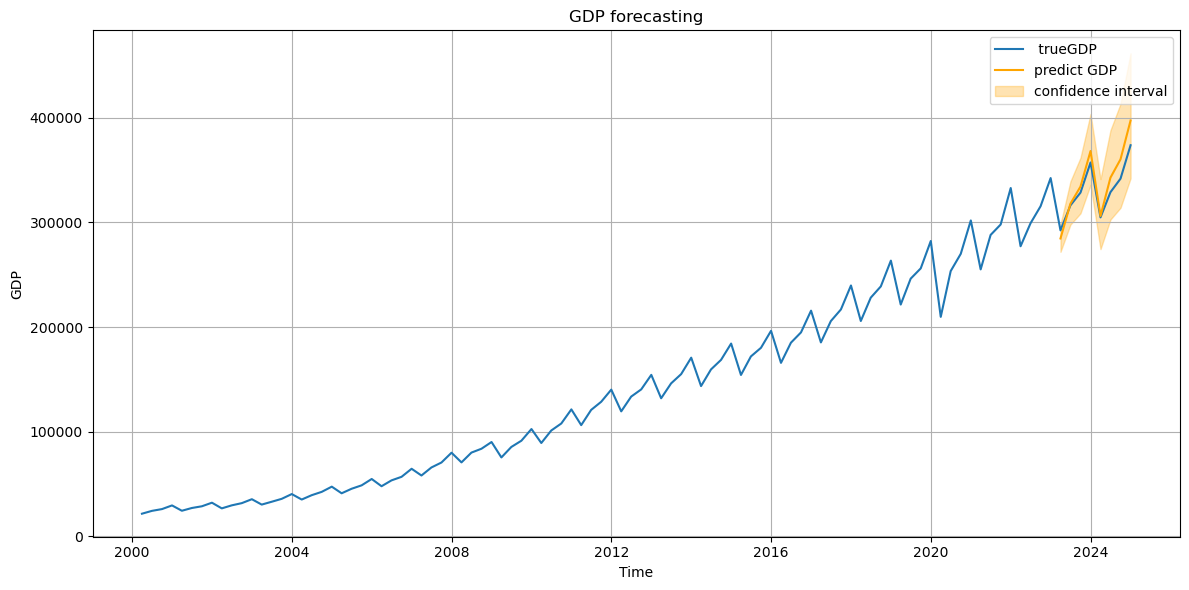

In [24]:
forecast = result.get_forecast(steps=8)
print(forecast.conf_int())
forecast_mean = np.exp(forecast.predicted_mean)       # 还原
conf_int = forecast.conf_int()
conf_int_exp = np.exp(conf_int) 

plt.figure(figsize=(12, 6))
plt.plot(data['gdp'], label=' trueGDP')
plt.plot(forecast_mean, label='predict GDP', color='orange')
plt.fill_between(conf_int_exp.index,
                 conf_int_exp.iloc[:, 0],
                 conf_int_exp.iloc[:, 1],
                 color='orange', alpha=0.3, label='confidence interval')
plt.title('GDP forecasting')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()